In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2  # conda install -c conda-forge opencv
import matplotlib.pyplot as plt

from utils.utils import get_video_properties, create_scalarmappable, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, transform_points_to_original_space, extract_segments_aligned
from scipy.signal import find_peaks
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.spatial import cKDTree
from utils.egocentric_utils import plot_colorline
from matplotlib.lines import Line2D

# Plotting standards
%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

# Figure params
SAVE_FIGURE = True
results_save_path = "./results/figures/leeching/"
os.makedirs(results_save_path, exist_ok=True)
fdict = dict(fname=f"", dpi=600, bbox_inches="tight", edgecolor=None)

# 1. Paths and Read-In (segmentation mask based)

In [2]:
# For the automation consider only the segemnted examples
masks_dir = "../data/videos/leeching/philodina/seg_masks/"
masks_path_names = sorted([dir for dir in os.listdir(masks_dir) if dir.endswith("masks")])
mask_filepaths = [f"{masks_dir}{mpath}/"for mpath in masks_path_names]

# Corresponding videos
vid_path = "../data/videos/leeching/philodina/ori_videos/"
vid_filenames = [fn.split("_masks")[0] + ".MP4" for fn in masks_path_names]
vid_props = {k : get_video_properties(vid_path, k) for k in vid_filenames}
df = pd.DataFrame.from_dict(vid_props, orient="index").reset_index()
df.columns = ["filename", "fps", "num_frames", "width", "height"]

# Scale
pixel_per_real_width =  2.127659 #  >> for Dlow
mpp = 0.47 # microns_per_pixel for Dlow
print("D low - FHD, pixel_per_real_width = ", pixel_per_real_width)
    
df

D low - FHD, pixel_per_real_width =  2.127659


,filename,fps,num_frames,width,height
0,2024_0430_200515_048.MP4,60,2354,1920,1080
1,2024_0502_183848_065.MP4,60,1038,1920,1080
2,2024_0502_184114_068.MP4,60,843,1920,1080
3,2024_0502_184450_071.MP4,60,2074,1920,1080
4,2024_0502_184534_072.MP4,60,2156,1920,1080
5,2024_0502_184616_073.MP4,60,1372,1920,1080
6,2024_0502_184929_077.MP4,60,776,1920,1080
7,2024_0502_184947_078.MP4,60,756,1920,1080
8,2024_0502_185400_083.MP4,60,1333,1920,1080
9,2024_0502_185557_084.MP4,60,1648,1920,1080


# 2. Select a recording

In [3]:
# Get Segmentation masks > results of tracking
cidx = 4  # 4, min_area=2200
vid_filename = df.loc[cidx, "filename"]; print(vid_filename)

fps = df.loc[cidx, "fps"]
num_frames = df.loc[cidx, "num_frames"]
width, height = df.loc[cidx, "width"], df.loc[cidx, "height"]
cmask_filepath = mask_filepaths[cidx]

# Masks
cmask_filenames = sorted([f for f in os.listdir(cmask_filepath) if f.endswith("png")])
cmask_filepaths = [os.path.join(cmask_filepath, fn) for fn in cmask_filenames]

# Set num_frames to the desired value > trows an unexpected error in the rotation function...
#num_frames = 1600
#cmask_filepaths = cmask_filepaths[:num_frames]

# Get contours from masks
frames = np.arange(0, len(cmask_filepaths))
time = np.linspace(0, num_frames / fps, num_frames)
frames_max = 1570 # previously: 1600
t_max = time[frames_max]

# Get contour stats
contour_list = get_contours_from_segmasks(cmask_filepaths)
df_stats = get_contour_stats(contour_list, min_area=2200)
print(df_stats["area"].min())

# Save figures
#results_path = "../data/results/leeching/"
save_figure_path = os.path.join(results_save_path, vid_filename.split(".MP4")[0])
os.makedirs(save_figure_path, exist_ok=True)

# export selected frames only
EXPORT_FRAMES = False
export_frames = np.arange(0, frames_max)  # export frames, rather!
img_save_dir = f"../data/images/{vid_filename.split('.MP4')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), img_save_dir, export_frames) if EXPORT_FRAMES else None

2024_0502_184534_072.MP4
2261.0


# 2. Rotate Masks and Contours

In [4]:
# Rotatation parameters
cm_x, cm_y = df_stats[["centroid_x", "centroid_y"]].values.T
centers = [(x, y) for x, y in zip(cm_x, cm_y)]
rot_angles = df_stats["orientation"].values  # fitted ellipse angle
print(np.isnan(centers).sum())

# rotate masks and get rotated contours
rot_masks, rot_contours = rotate_masks_and_contours(centers, rot_angles, cmask_filepaths)
# find top and bottom most points
df_top_bot = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours))
df_points = transform_points_to_original_space(df_top_bot, centers, rot_angles * -1)

2


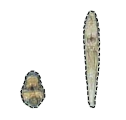

In [5]:

# add example image back-front marked into this plot
#frame_index 100 und 200!
example_frames = [100, 200]
zfill_ = 5
example_mask_paths = [cmask_filepaths[fr] for fr in example_frames]
example_image_paths = [os.path.join(img_save_dir, f"frame_{str(fr).zfill(zfill_)}.jpg") for fr in example_frames]
example_centers = [centers[fr] for fr in example_frames]
example_rot_angles = [rot_angles[fr] for fr in example_frames]

_, example_rot_contours = rotate_masks_and_contours(example_centers, example_rot_angles, example_mask_paths)
example_rot_masks, example_rot_images = rotate_masks_and_images(example_centers, example_rot_angles, example_mask_paths, example_image_paths)
df_top_bot_example = pd.DataFrame(find_top_bottom_points_from_contours(example_rot_contours))

background = np.ones_like(example_rot_images[0]) * 255
#background = np.zeros_like(example_rot_images[0])
masked_images = []

for mask, img in zip(example_rot_masks, example_rot_images):
    #img = cv2.cvtColor(cv2.imread(sel_img, 1), cv2.COLOR_BGR2RGB)
    #mask = cv2.cvtColor(cv2.imread(sel_mask, 1), cv2.COLOR_BGR2GRAY)
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    masked_image = np.uint8((masked_image / np.max(masked_image)) * 253)
    masked_image = np.where(masked_image != 0, masked_image, background)
    masked_images.append(masked_image)

fig, ax = plt.subplots(1, 2, figsize=(2, 2))
ax[0].imshow(masked_images[0])
ax[0].plot(example_rot_contours[0][:, 0, 0], example_rot_contours[0][:, 0, 1], "--k", lw=1)
ax[0].set(xlim=(df_top_bot_example.top_x[0]-50, df_top_bot_example.top_x[0]+50), ylim=(df_top_bot_example.top_y[0]-10,df_top_bot_example.top_y[0]+200))
ax[0].axis("off")
#ax[0].legend()

ax[1].imshow(masked_images[-1])
ax[1].plot(example_rot_contours[1][:, 0, 0], example_rot_contours[1][:, 0, 1], "--k", lw=1)
ax[1].set(xlim=(df_top_bot_example.top_x[1]-50, df_top_bot_example.top_x[1]+50), ylim=(df_top_bot_example.top_y[1]-10,df_top_bot_example.top_y[1]+200))
ax[1].axis("off")

fig.savefig(f"{save_figure_path}/back-front-example_frames.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None
# plot the back + front points
# relook code to make it simpler!!!

255 1


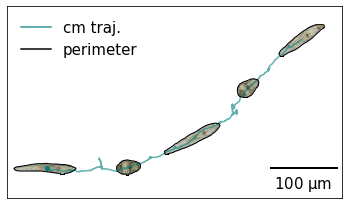

In [6]:
# rotate selected images, masks etc
selected_frames = [25, 395, 650, 1225, 1565]

zfill_ = 5
selected_mask_paths = [cmask_filepaths[fr] for fr in selected_frames]
selected_image_paths = [os.path.join(img_save_dir, f"frame_{str(fr).zfill(zfill_)}.jpg") for fr in selected_frames]
selected_centers = [centers[fr] for fr in selected_frames]
selected_rot_angles = [rot_angles[fr] for fr in selected_frames]

contour_list = get_contours_from_segmasks(selected_mask_paths)

rot_masks_sel, rot_contours_sel = rotate_masks_and_contours(selected_centers, selected_rot_angles, selected_mask_paths)
_, rot_images_sel = rotate_masks_and_images(selected_centers, selected_rot_angles, selected_mask_paths, selected_image_paths)

df_top_bot_sel = pd.DataFrame(find_top_bottom_points_from_contours(rot_contours_sel))
df_stats_sel = df_stats.iloc[selected_frames]

# Normalize contours by centers
background = np.zeros_like(rot_images_sel[0])
masked_images = []

for sel_mask, sel_img in zip(selected_mask_paths, selected_image_paths):
    img = cv2.cvtColor(cv2.imread(sel_img, 1), cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(cv2.imread(sel_mask, 1), cv2.COLOR_BGR2GRAY)
    masked_image = cv2.bitwise_and(img, img, mask=mask)
    masked_images.append(masked_image)

# Merge frames
merged_frame = np.zeros_like(rot_images_sel[0])
for frame in masked_images:
    merged_frame = cv2.add(merged_frame, frame)

# rescale merged frame
merged_frame = np.uint8((merged_frame / np.max(merged_frame)) * 253)

# Add white as background
background = np.ones_like(rot_images_sel[0]) * 255
merged_frame = np.where(merged_frame != 0, merged_frame, background)
print(np.max(merged_frame), np.min(merged_frame))


# Plotting
ts = selected_frames[0]
te = selected_frames[-1]
ax_params = dict(xlim=(700, 1750), ylim=(350, 950), xticks=[], yticks=[])

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(merged_frame)
ax.plot(cm_x[ts:te], cm_y[ts:te], "-", color="teal", alpha=.6, label="com traj.")
ax.plot(cm_x[ts], cm_y[ts], "o", color="teal", ms=4, mec=None, label="start")
#ax.plot(cm_x[te], cm_y[te], "s", color="k", ms=4, mec=None, label="stop")
for ccontour in contour_list:
    ax.plot(ccontour[:, 0, 0], ccontour[:, 0, 1], "-k", lw=1)
    ax.plot([ccontour[0, 0, 0], ccontour[-1, 0, 0]], [ccontour[0, 0, 1], ccontour[-1, 0, 1]], "-k", lw=1)

ax.set(**ax_params)
ax.invert_xaxis()
#ax.legend(frameon=False)

legend_patches = [
    Line2D([0], [0], marker='None', color='teal', label='cm traj.', linestyle="-", alpha=.8),
    Line2D([0], [0], marker='None', color='black', label='perimeter', linestyle="-")
]

ax.legend(handles=legend_patches, frameon=False, loc="upper left")

for spine in ax.spines.values():
    spine.set_visible(True)

# Scalebar
scalebar = ScaleBar(mpp, units="µm", location="lower right", scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar)

fdict["fname"] = f"{save_figure_path}/cm-trajectory-blended-images-example.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Aligned movement

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


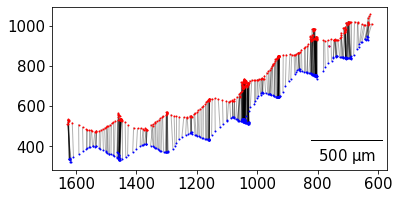

In [7]:
every_nth = 6
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
for i in range(0, len(df_top_bot), every_nth):
    ax.plot([df_top_bot["top_x"].iloc[i], df_top_bot["bottom_x"].iloc[i]],
             [df_top_bot["top_y"].iloc[i], df_top_bot["bottom_y"].iloc[i]], 'k-', lw=1, alpha=.3)

ax.plot(df_top_bot["top_x"][::every_nth], df_top_bot["top_y"][::every_nth], "ob", ms=2, alpha=1, label="back", mec="None")
ax.plot(df_top_bot["bottom_x"][::every_nth], df_top_bot["bottom_y"][::every_nth], "or", ms=2, alpha=1, label="front", mec="None")
ax.invert_xaxis()
for spine in ax.spines.values():
    spine.set_visible(True)
#ax.set(xticks=[], yticks=[])
# Scalebar
scalebar = ScaleBar(1/mpp, units="µm", location="lower right", scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar)

fdict["fname"] = f"{save_figure_path}/back-front-time-course_every{every_nth}_frame.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


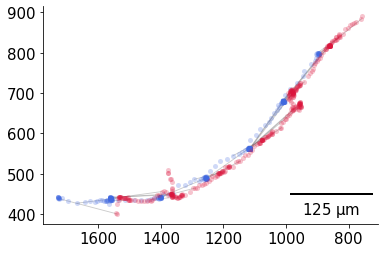

In [8]:
idx = np.arange(0, frames_max, 60)
stepsize_ = 5
plot_params = {"back" : dict(color="royalblue", alpha=.25, marker="o", markersize=5, mec="None", label="back", linestyle="None", zorder=1),
               "front" : dict(color="crimson", alpha=.25, marker="o", markersize=5, mec="None", label="front", linestyle="None", zorder=2),
               "cline" : dict(color="gray", alpha=.4, label="cline", linestyle="-", linewidth=.9, zorder=0)}

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(df_points["top_x"].iloc[0:frames_max:stepsize_], df_points["top_y"].iloc[0:frames_max:stepsize_], **plot_params["back"])
ax.plot(df_points["bottom_x"].iloc[0:frames_max:stepsize_], df_points["bottom_y"].iloc[0:frames_max:stepsize_], **plot_params["front"])

for bx, by, tx, ty in zip(df_points["bottom_x"][idx], df_points["bottom_y"][idx],
                           df_points["top_x"][idx], df_points["top_y"][idx]):
    ax.plot([bx, tx], [by, ty], **plot_params["cline"])

ax.invert_xaxis()
# Scalebar
scalebar = ScaleBar(mpp, units="µm", location="lower right", scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar)
#fdict["fname"] = f"{save_figure_path}/perimeter_and_BF-velocity_time-course_2.jpg"
#fig.savefig(**fdict) if SAVE_FIGURE else None

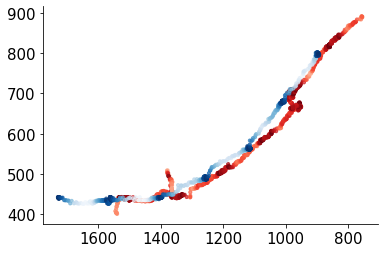

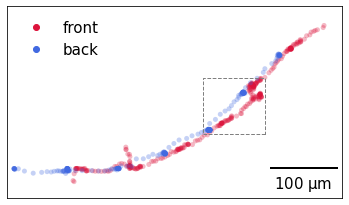

In [9]:
cols = ["top_x", "top_y", "bottom_x", "bottom_y"]
sliceby = 5  # impact on visualization but also on displacement!!! probably seperate slicing for visualization and calculation!

# New df with proper slicing
df_points2 = df_points.iloc[:frames_max].copy()  # all points
cm_x_, cm_y_ = (df_stats.loc[:frames_max, c] for c in ["centroid_x", "centroid_y"])

x, y, x2, y2 = (df_points2[col] for col in cols)

# Moving average
wsize = 15
df_points2["top_disp"] = np.sqrt(x.diff().rolling(window=wsize).mean() ** 2 + y.diff().rolling(window=wsize).mean() ** 2)
df_points2["bottom_disp"] = np.sqrt(x2.diff().rolling(window=wsize).mean() ** 2 + y2.diff().rolling(window=wsize).mean() ** 2)
cm_xy_disp = np.sqrt(cm_x_.diff().rolling(window=wsize).mean() ** 2 + cm_y_.diff().rolling(window=wsize).mean() ** 2)

# Fill NaNs
back = df_points2["top_disp"].bfill().ffill()
front = df_points2["bottom_disp"].bfill().ffill()

# Plotting
scatter_params = {"back" : dict(color="royalblue", alpha=.3, marker="o", s=25, edgecolor="None", label="back", linestyle="None", zorder=2),
                  "front" : dict(color="crimson", alpha=.3, marker="o", s=25, edgecolor="None", label="front", linestyle="None", zorder=1)
                  }

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x2, y2, c=front, s=10,cmap='Reds_r', alpha=.7)
ax.scatter(x, y, c=back, s=10,cmap='Blues_r', alpha=.7)
ax.invert_xaxis()

# Plot savefigure
ax_params = dict(xlim=(700, 1750), ylim=(350, 950), xticks=[], yticks=[])

fig, ax = plt.subplots(figsize=(6,4))
#background = np.ones_like(rot_images_sel[0]) * 255
ax.imshow(background)
ax.scatter(x2[::sliceby], y2[::sliceby], **scatter_params["front"])
ax.scatter(x[::sliceby], y[::sliceby], **scatter_params["back"])
for spine in ax.spines.values():
    spine.set_visible(True)

ax.set(**ax_params)
scalebar = ScaleBar(mpp, units="µm", location="lower right", scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar)

legend_patches = [
    Line2D([0], [0], marker='o', color='crimson', label='front', linestyle="None"),
    Line2D([0], [0], marker='o', color='royalblue', label='back', linestyle="None")]
ax.legend(handles=legend_patches, frameon=False, loc="upper left")

from utils.piv_utils import plot_bbox
bbox = (940, 1135, 550, 725)
plot_bbox(bbox, c="gray", ax=ax)
ax.invert_xaxis()

fdict["fname"] = f"{save_figure_path}/front-back-scatter-path.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

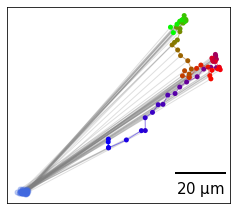

In [10]:
start_time, end_time = 750, 1100
idx = np.arange(start_time, end_time, sliceby)
xl, yl = list(), list()
colors, _ = create_scalarmappable("brg", range(len(idx)))
fig, ax = plt.subplots(figsize=(4,4))

for nth, (bx, by, tx, ty) in enumerate(zip(x2[idx], y2[idx], x[idx], y[idx])):
    x_, y_ = bx - tx, by - ty
    xl.append(x_), yl.append(y_)
    ax.plot([bx, tx], [by, ty], "-", lw=1, alpha=.25, color="gray") ##ax.plot([0, x_], [0, y_], "-", lw=1, alpha=.25, color="gray")
    
ax.scatter(x[idx], y[idx], color="royalblue", s=25, alpha=.3, zorder=5)
plot_colorline(x2[idx], y2[idx], colors=colors, ax=ax, lw=1, zorder=6, alpha=.5)
ax.scatter(x2[idx], y2[idx], c=colors, alpha=1, s=25, edgecolor="None", zorder=5)
ax.invert_xaxis()
for spine in ax.spines.values():
    spine.set_visible(True)
ax.set(xticks=[], yticks=[])
ax.set_aspect(1)

scalebar = ScaleBar(mpp, units="µm", location="lower right", scale_loc="bottom", length_fraction=0.25, box_alpha=.25)
ax.add_artist(scalebar)

fdict["fname"] = f"{save_figure_path}/front-back-scatter-cutout-bbox.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

In [11]:
# # Histogram2D
# stepsize = 25
# x_bins = np.arange(0, width, stepsize)
# y_bins = np.arange(0, height, stepsize)

# # Compute 2D histogram
# H, xedges, yedges = np.histogram2d(x, y, bins=[x_bins, y_bins])
# ax_params = dict(xlim=(0, 1125), ylim=(350, 900))

# fig, ax = plt.subplots(1,2,figsize=(12,6))
# ax[0].imshow(H.T, origin="lower", extent=[xedges[-1], xedges[0], yedges[0], yedges[-1]], aspect="equal", cmap="Blues", norm="log")
# ax[0].set(**ax_params)
# ax[1].hexbin(x, y, gridsize=50, cmap='Blues', mincnt=1, norm="log")

# # Nearest neighbors
# points = np.vstack([x, y]).T
# points2 = np.vstack([x2, y2]).T

# # Nearest neighbors
# n = 5  # n-te Nachbarn (beachte: self zählt als nächster Nachbar)
# tree = cKDTree(points)
# tree2 = cKDTree(points2)

# distances, _ = tree.query(points, k=n+1)  # +1, da der eigene Punkt immer dabei ist
# nth_distances = distances[:, -1]  # Abstand zum n-ten Nachbarn
# distances2, _ = tree.query(points2, k=n+1)
# nth_distances2 = distances2[:, -1]

# fig, ax = plt.subplots(figsize=(6,4))
# sc = plt.scatter(x, y, c=nth_distances, s=10, cmap='Blues_r', alpha=.7)
# sc = plt.scatter(x2, y2, c=nth_distances2, s=10, cmap='Reds_r', alpha=.7)
# plt.axis("equal")
# ax.invert_xaxis()

# fig, ax = plt.subplots(figsize=(6,4))
# ax.plot(back, "-b", lw=1, alpha=.5)
# ax.plot(front, "-r", lw=1, alpha=.5)
# #ax.plot(nth_distances, "-b", lw=1, alpha=.5)
# #ax.plot(nth_distances2, "--", lw=1, alpha=.5, color="darkred")

In [12]:
# wsize=15
# smooth_centroid_dist = df_stats["centroid_dist"].rolling(window=wsize).mean()
# # back = np.sqrt(df_points["top_x"].diff().rolling(window=wsize).mean() ** 2 + df_points["top_y"].diff().rolling(window=wsize).mean() ** 2)
# # front = np.sqrt(df_points["bottom_x"].diff().rolling(window=wsize).mean() ** 2 + df_points["bottom_y"].diff().rolling(window=wsize).mean() ** 2)
# back = np.sqrt(df_points["top_x"].diff().ewm(span=wsize, adjust=False).mean() ** 2 + df_points["top_y"].diff().ewm(span=wsize, adjust=False).mean() ** 2)
# front = np.sqrt(df_points["bottom_x"].diff().ewm(span=wsize, adjust=False).mean() ** 2 + df_points["bottom_y"].diff().ewm(span=wsize, adjust=False).mean() ** 2)

# back_ = pd.Series(np.sqrt(df_points["top_x"].diff() ** 2 + df_points["top_y"].diff() ** 2)).rolling(window=wsize).mean()
# front_ = pd.Series(np.sqrt(df_points["bottom_x"].diff() ** 2 + df_points["bottom_y"].diff() ** 2)).rolling(window=wsize).mean()
# # df['ewma'].fillna(method='bfill', inplace=True)

# fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(time[:frames_max], front[:frames_max], color="red", alpha=.75, linewidth=1.0, label="front")
# ax.plot(time[:frames_max], back[:frames_max], color="blue", alpha=.75, linewidth=1.0, label="back")

# fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(time[:frames_max], front_[:frames_max], color="red", alpha=.75, linewidth=1.0, label="front")
# ax.plot(time[:frames_max], back_[:frames_max], color="blue", alpha=.75, linewidth=1.0, label="back")

# fig, ax = plt.subplots(figsize=(6, 4))
# ax.plot(time[:frames_max], back[:frames_max], color="lightblue", alpha=.75, linewidth=1.0, label="front")
# ax.plot(time[:frames_max], back_[:frames_max], color="blue", alpha=.75, linewidth=1.0, label="back")

# Time Plotting

In [13]:
# fig, ax = plt.subplots()
# ax.plot(time[:frames_max], front * fps * mpp, color="crimson", alpha=.75, linewidth=1.0, label="front")
# ax.plot(time[:frames_max], back * fps * mpp, color="royalblue", alpha=.75, linewidth=1.0, label="back")
# fig, ax = plt.subplots()
# ax.plot(time, df_stats["perimeter"] * (mpp), "-k", lw=2)

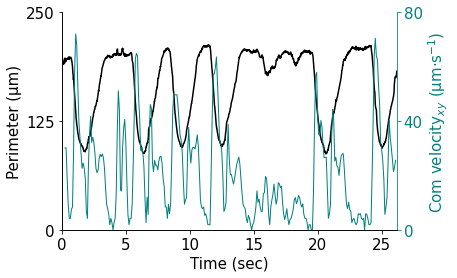

In [14]:
# With back and front
ax_params = dict(xlim=(0, t_max), ylim=(0, 250), xlabel='Time (sec)', ylabel='Perimeter (µm)', yticks=[0, 125, 250])
ax2_params = dict(ylim=(0, 80), yticks=[0,40,80], ylabel="Com velocity$_x$$_y$ (µm·s$^{-1}$)")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time, df_stats["perimeter"] * (mpp), "-k", lw=1.5, zorder=3)
ax.set(**ax_params)
ax.tick_params(axis='both', which='major')#, labelsize=12)

# MIND THAT THERE IS STUFF BEYOND XLIM!!!!
ax2 = plt.twinx()
ax2.plot(time[0:frames_max:sliceby], cm_xy_disp[0:frames_max:sliceby] * fps * mpp, color="teal", linewidth=1, label="cm_xy_disp", zorder=0)
ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color("teal")
ax2.yaxis.label.set_color("teal")
ax2.set(**ax2_params)
ax2.tick_params(axis="y", color="teal")
ax2.set_yticklabels(labels=[0,40,80], color="teal")

fdict["fname"] = f"{save_figure_path}/perimeter_and_com-velocity_time-course_2.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

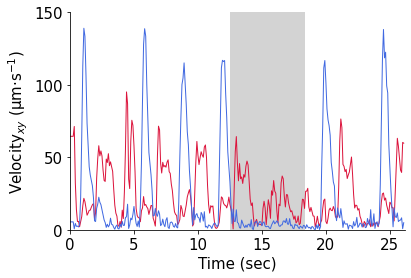

In [32]:
# With back and front
ax_params = dict(xlim=(0, t_max), ylim=(0, 150), xlabel='Time (sec)', ylabel="Velocity$_x$$_y$ (µm·s$^{-1}$)", yticks=[0, 50, 100, 150])

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(time[0:frames_max:sliceby], front[::sliceby] * fps * mpp, color="crimson", linewidth=1, label="front", zorder=1)
ax.plot(time[0:frames_max:sliceby], back[::sliceby] * fps * mpp, color="royalblue", linewidth=1, label="back", zorder=2)
ax.fill_between(x=[time[start_time], time[end_time]], y1=[150, 150], y2=[0,0], step="mid", color="lightgrey", alpha=1, zorder=0, ec="None")
ax.set(**ax_params)

fdict["fname"] = f"{save_figure_path}/front_back-velocity_time-course_2.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

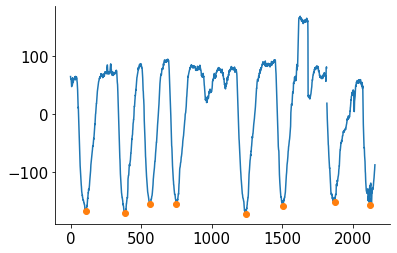

In [16]:
signal = df_stats["perimeter"].to_numpy()
signal = signal - np.nanmean(signal)
troughs, _ = find_peaks(-signal, distance=120, height=0)  # Adjust distance as needed

plt.plot(frames, signal)
plt.plot(frames[troughs], signal[troughs], "o", label="troughs")

# here need front not downsampled!!

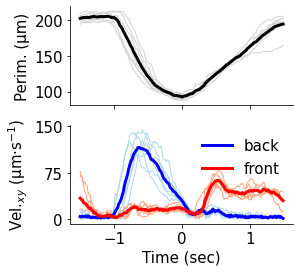

In [17]:
# New df with proper slicing
df_points2 = df_points.iloc[:frames_max].copy()
x, y, x2, y2 = (df_points2[col] for col in cols)

# Moving average
df_points2["top_disp"] = np.sqrt(x.diff().rolling(window=wsize).mean() ** 2 + y.diff().rolling(window=wsize).mean() ** 2)
df_points2["bottom_disp"] = np.sqrt(x2.diff().rolling(window=wsize).mean() ** 2 + y2.diff().rolling(window=wsize).mean() ** 2)

# Fill NaNs
back = df_points2["top_disp"].bfill().ffill()
front = df_points2["bottom_disp"].bfill().ffill()

before, after = 90, 90
t_aligned = np.arange(-before, after) / fps
tperimeter = df_stats["perimeter"].to_numpy() * (mpp)

aligned_segments = extract_segments_aligned(tperimeter, troughs[:-1], before=before, after=after)
aligned_front = extract_segments_aligned(front * fps * mpp, troughs[:-1])
aligned_back = extract_segments_aligned(back * fps * mpp, troughs[:-1])

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(4,4))
ax[0].plot(t_aligned, aligned_segments.T, "-", lw=1, color="lightgray");
ax[0].plot(t_aligned, np.nanmean(aligned_segments, axis=0), "-k", lw=3);
ax[0].set(xticklabels=[], ylabel="Perim. (µm)")

ax[1].plot(t_aligned, aligned_front.T, "-", color="lightsalmon", lw=1);
ax[1].plot(t_aligned, aligned_back.T, "-", color="lightblue", lw=1);

ax[1].plot(t_aligned, np.nanmean(aligned_back, axis=0), "-b", lw=3, label="back"); #"cm$_b$"
ax[1].plot(t_aligned, np.nanmean(aligned_front, axis=0), "-r", lw=3, label="front"); # cm$_f$"
ax[1].set(xlabel="Time (sec)", ylabel="Vel.$_x$$_y$ (µm·s$^{-1}$)", yticks=[0, 75, 150])
ax[1].legend(frameon=False)

fdict["fname"] = f"{save_figure_path}/perimeter_and_BF-trough-triggered.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

# Compound figure

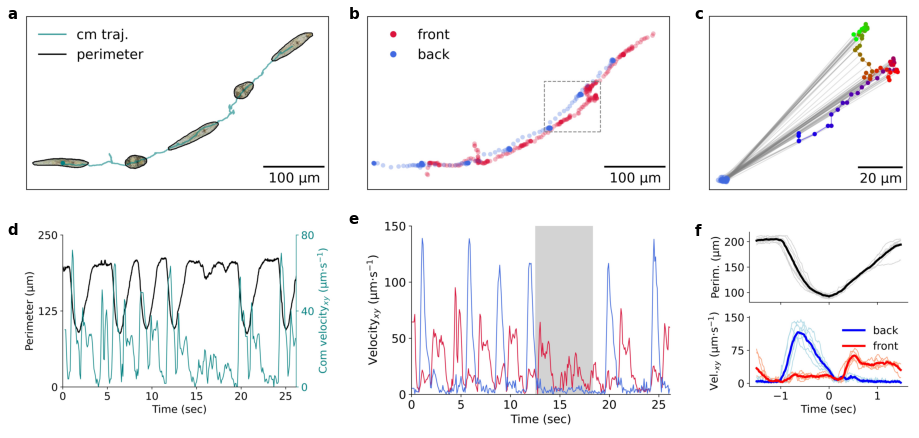

In [33]:
import matplotlib.image as mpimg
compound_figure_path = os.path.join(results_save_path, "compound_figures")
os.makedirs(compound_figure_path, exist_ok=True)

image_strs = [
    "cm-trajectory-blended-images-example.jpg",
    "front-back-scatter-path.jpg",
    "front-back-scatter-cutout-bbox.jpg",
    
    "perimeter_and_com-velocity_time-course_2.jpg",
    "front_back-velocity_time-course_2.jpg",
    "perimeter_and_BF-trough-triggered.jpg",]
image_files = [f"{save_figure_path}/{img}" for img in image_strs]

panel_labels = ["a", "b", "c", "d", "e", "f"]
fig_width = 16 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .095

fig, axes = plt.subplots(2, 3, figsize=(fig_width, 8), gridspec_kw={"hspace": 0.025, "wspace": wspace}, width_ratios=[1.5, 1.5, 1])
axes = axes.flatten()

for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-figure-leeching-1-{panel_labels[0]}-to-{panel_labels[-1]}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

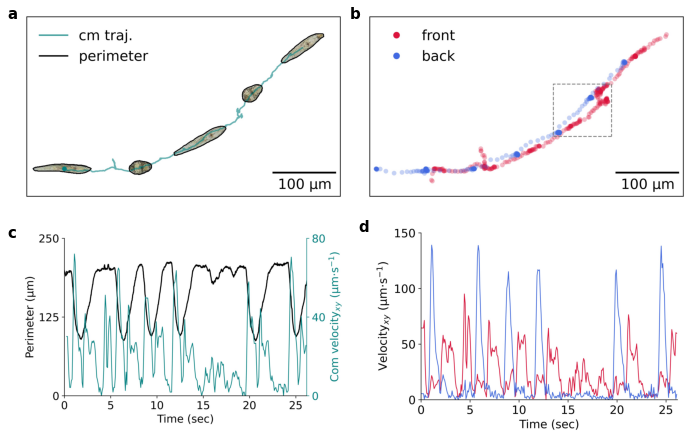

In [19]:
import matplotlib.image as mpimg
compound_figure_path = os.path.join(results_save_path, "compound_figures")
os.makedirs(compound_figure_path, exist_ok=True)

image_strs = [
    "cm-trajectory-blended-images-example.jpg",
    "front-back-scatter-path.jpg",
    "perimeter_and_com-velocity_time-course_2.jpg",
    "front_back-velocity_time-course_2.jpg"]
image_files = [f"{save_figure_path}/{img}" for img in image_strs]

panel_labels = ["a", "b", "c", "d"]
fig_width = 12 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .05

fig, axes = plt.subplots(2, 2, figsize=(fig_width, 8), gridspec_kw={"hspace": 0.05, "wspace": wspace})
axes = axes.flatten()

for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-figure-leeching-1-{panel_labels[0]}-to-{panel_labels[-1]}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

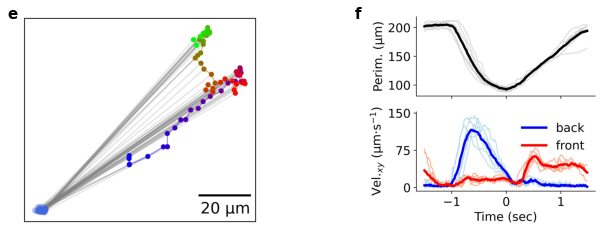

In [20]:
image_strs = [
    "front-back-scatter-cutout-bbox.jpg",
    "perimeter_and_BF-trough-triggered.jpg",
]
image_files = [f"{save_figure_path}/{img}" for img in image_strs]

panel_labels = ["e", "f"]
fig_width = 12 # 8.27  # Standardbreite (A4 = 8.27 Zoll)
wspace = .05

fig, axes = plt.subplots(1, 2, figsize=(fig_width, 4), gridspec_kw={"hspace": 0.05, "wspace": wspace})
axes = axes.flatten()

for ax, file, label in zip(axes, image_files, panel_labels):
    img = mpimg.imread(file)
    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.04, 1.02, label, transform=ax.transAxes, fontsize=15, fontweight='bold', va='top', ha='left')

fdict["fname"] = f"{compound_figure_path}/compound-figure-leeching-1-{panel_labels[0]}-to-{panel_labels[-1]}.jpg"
fig.savefig(**fdict) if SAVE_FIGURE else None

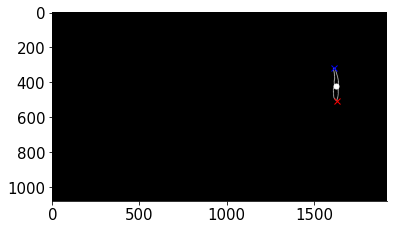

In [21]:
idx = 2
cmask = cv2.cvtColor(cv2.imread(cmask_filepaths[idx], 1), cv2.COLOR_BGR2GRAY)
background = np.zeros_like(cmask)

cv2.drawContours(background, [rot_contours[idx]], 0, (255,0,0), thickness=2)
plt.imshow(background, cmap="gray")
plt.plot(cm_x[idx], cm_y[idx], "ow", ms=5)

plt.plot(df_top_bot.loc[idx, "top_x"], df_top_bot.loc[idx, "top_y"], "xb", ms=6)
plt.plot(df_top_bot.loc[idx, "bottom_x"], df_top_bot.loc[idx, "bottom_y"], "xr", ms=6)

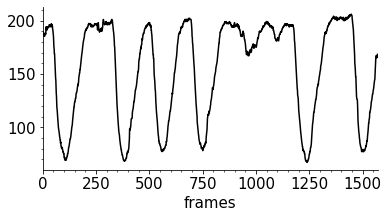

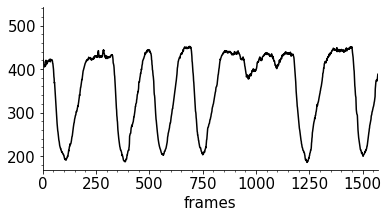

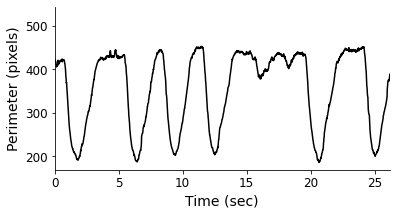

In [22]:
df_top_bot = df_top_bot[:frames_max]
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(frames[:frames_max], df_top_bot["distance"], "-k")
ax.set_xlim(0, frames_max)
ax.set_xlabel("frames")
ax.minorticks_on()
fig.savefig(f"{save_figure_path}/length_frames-course.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(frames, df_stats["perimeter"], "-k")
ax.set_xlim(0, frames_max)
ax.set_xlabel("frames")
ax.minorticks_on()
fig.savefig(f"{save_figure_path}/perimeter_frames-course.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

# TAKE CARE OF FONTSIZES!!!!
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(time, df_stats["perimeter"], "-k")
ax.set_xlim(0, t_max)
ax.set_xlabel('Time (sec)', fontsize=14)
ax.set_ylabel('Perimeter (pixels)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
fig.savefig(f"{save_figure_path}/perimeter_time-course.jpg", dpi=600, bbox_inches='tight') if SAVE_FIGURE else None

## Doesnt look too good because low resolution video!

In [23]:
# centered_contours_sel = normalize_contours_by_centers(rot_contours_sel, selected_centers)
# shifted_contours = shift_contours(centered_contours_sel, 1000, 500)

# plt.figure()
# for contour in centered_contours_sel:
#     plt.plot(contour[:,:,0], contour[:,:,1], color='blue')
# plt.axis("equal")

# desired_cmap = "coolwarm" # "coolwarm"
# cmap = plt.get_cmap(desired_cmap)
# colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(shifted_contours))]

# background = np.ones_like(rot_images_sel[0]) * 0#255

# for nth, contour in enumerate(shifted_contours):
#     ccolors = colors[nth]
#     ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
#     cv2.drawContours(background, [contour], 0, (ccolors[0], ccolors[1], ccolors[2]), 1)

# #plt.imshow(background, cmap="coolwarm")
# plt.figure(figsize=(5,6), layout="constrained")
# plt.imshow(background)
# plt.xlim(950,1050), plt.ylim(350,600)

# background = np.zeros_like(rot_masks_sel[0])
# plt.figure()
# cv2.drawContours(background, rot_contours_sel, -1, (255,0,0), thickness=2)
# plt.imshow(background, cmap="gray")
# #plt.plot(cm_x[idx], cm_y[idx], "ow", ms=10)